1. [Generate GRF](#Generate-GRF)
2. [Random walk sigma](#Random-walk-k$_{max}$)
3. [Test code for moments](#Incomplete-and-specific-codes)

In [1]:
#Set warnings to show always
import warnings
warnings.filterwarnings('always')
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pyfftw
import scipy.stats as stats
from scipy.stats import moment

In [2]:
#Decorate plots (Shadab's code but a little more flexible)
import matplotlib.ticker as ticker

def tick_marks(ax, x1=0, x2=0, nx=0, dx=1, y1=0, y2=0, ny=0, dy=0, majortick_size=15, minortick_size=8, 
               majortick_width=2, minortick_width=1.5, tick_label_size=18, spwid=2):
    plt.sca(ax)
    #setting tickmarks
    if(nx>0):
        minorLocator_x   = ticker.MultipleLocator((x2-x1-dx)/(nx*5.0))
        ax.xaxis.set_minor_locator(minorLocator_x)
        #dx=(x2-x1)/nx/5
        plt.xticks(np.round(np.linspace(x1+dx,x2,nx),2),fontsize=18)
        plt.xlim([x1,x2])
    elif(nx==-1):
        plt.xticks([])
    else:
        xscale=ax.get_xscale()
        majorloc_x=ax.get_xticks()
        if('linear' in xscale):
            minorloc_x   = ticker.MultipleLocator((majorloc_x[-1]-majorloc_x[0])/((majorloc_x.size-1)*5.0))
            ax.xaxis.set_minor_locator(minorloc_x)
        if('log' in xscale):
            minorloc_x=[majorloc_x[0]]
            for mm in majorloc_x[:-1]:
                for jj in range(1,10):
                    minorloc_x.append(minorloc_x[-1]+mm)
            ax.xaxis.set_minor_locator(ticker.FixedLocator(minorloc_x))
            ax.xaxis.set_minor_formatter(plt.NullFormatter())
        

    if(ny>0):
        minorLocator_y   = ticker.MultipleLocator((y2-y1-dy)/(ny*5.0))
        ax.yaxis.set_minor_locator(minorLocator_y)
        plt.yticks(np.round(np.linspace(y1+dy,y2,ny),2),fontsize=20)
        plt.ylim([y1,y2])
    elif(ny==-1):
        plt.yticks([]) 
    else:
        yscale=ax.get_yscale()
        majorloc_y=ax.get_yticks()
        if('linear' in yscale):
            minorloc_y   = ticker.MultipleLocator((majorloc_y[-1]-majorloc_y[0])/((majorloc_y.size-1)*5.0))
            ax.yaxis.set_minor_locator(minorloc_y)
        if('log' in yscale):
            minorloc_y=[majorloc_y[0]]
            for mm in majorloc_y[:-1]:
                for jj in range(1,10):
                    minorloc_y.append(minorloc_y[-1]+mm)
            ax.yaxis.set_minor_locator(ticker.FixedLocator(minorloc_y))
            ax.yaxis.set_minor_formatter(plt.NullFormatter())

    
    plt.tick_params('both', length=majortick_size, width=majortick_width, which='major', 
                    labelsize=tick_label_size,direction='inout')
    plt.tick_params('both', length=minortick_size, width=minortick_width, which='minor',
                    labelsize=tick_label_size,direction='inout')

    #ax=fig.add_subplot(111)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(spwid)

    return 

# Generate GRF

$f(nL) = \frac{1}{NL}\sum_{m=0}^{N-1}G(k)e^{-i2\pi mn/N}$  
where,  
$N$ is the number of intervals on each axis of the box in real space. The points in this box are seperated by distance $L$. $n$ and $m$ vary from $0,1,2,\dotsc,N-1$.  

$k$ in $G(k)$ comes from $2*\pi*\texttt{np.fft.fftfreq}$.

We will have to divide the result of numpy FFT by $N*L$ to get the same convention as that in _Bagla & Padmanabhan_

In [3]:
def p(k_vec, dim, p_pow=0):
    '''
    Return power spectrum evaluated at given k-values.
    Parameters:
    ----
    k_vec: Vector of k-values as numpy array of size (N,1). This follows the convention 2*np.pi*np.fft.fftfreq(N)
    dim: Dimention of the field. Possible values are 1, 2, 3.
    p_pow: (default=0) Spectral power of the power spectrum.
    
    Return :
    ----
    Power spectrum evaluated on a given grid.
    '''
    
    if dim == 1:
        k_mesh = np.meshgrid(k_vec, sparse=True)
    elif dim == 2:
        k_mesh = np.meshgrid(k_vec, k_vec, sparse=True)
    elif dim == 3:
        k_mesh = np.meshgrid(k_vec, k_vec, k_vec, sparse=True)
        
    ps_grid = k_mesh[0]**2
    for kaxis in k_mesh[1:]:
        ps_grid = ps_grid + kaxis**2
        
    ps_grid = np.sqrt(ps_grid)
    ps_eval = np.power(ps_grid, p_pow)
    ps_eval[ps_eval == np.inf] = 0
    
    return ps_eval        
            
def generate_mask(N, dim, n_remove):
    '''
    Generate a mask to apply a filter based on frequency selection.
    
    Parameters:
    ----
    N: number of intervals on each axis
    dim: Dimention of the field. Possible values are 1, 2, 3.
    n_remove (<= int(N/2)): Number of frequencies to remove from the high-k end i.e. decrease the k_max or say 
    that fluctuations at smaller scales are not important.
    
    Return:
    ----
    None if n_remove > int(N/2)
    A numpy array containing 0 for frequencies that are to be removed and 1 for all other frequencies.
    This array has shape (N,)/(N,N)/(N,N,N) depending on the value of dim. 
    '''
    
    if n_remove > int(N/2):
        print("More frequencies to remove than existing")
        return None
    amp_mask = np.ones(shape=[N for i in range(dim)])
    
    if n_remove == 0: return amp_mask
    
    if dim == 1:
        amp_mask[int(N/2) - n_remove:int(N/2) + n_remove + 1] = 0
    elif dim == 2:
        amp_mask[int(N/2) - n_remove:int(N/2) + n_remove + 1, int(N/2) - n_remove:int(N/2) + n_remove + 1] = 0
    elif dim == 3:
        amp_mask[int(N/2) - n_remove:int(N/2) + n_remove + 1, int(N/2) - n_remove:int(N/2) + n_remove + 1,
                int(N/2) - n_remove:int(N/2) + n_remove + 1] = 0
    
    return amp_mask

def get_amplitude(N, dim, L, p_pow, random_seed=None):
    '''
    Evaluate G(k) by multiplying the white noise to the square root of power spectrum.
    
    Parameters:
    ----
    N: Size of the box.
    dim: Dimention of the field. Possible values are 1, 2, 3.
    L: Seperation between points along axes in the box.
    p_pow: Spectral power of the power spectrum.
    random_seed: (default=None) Value of seed that is used to generate white noise.
    
    Return:
    ----
    A numpy array containing G(k) evaluated on the given grid.
    This array has shape (N,)/(N,N)/(N,N,N) depending on the value of dim.
    '''
    
    if random_seed is not None:
        np.random.seed(random_seed)
    
    k_vec = 2*np.pi*np.fft.fftfreq(N)

    random_field = np.fft.fftn(np.random.normal(size=[N for i in range(dim)]))

    ps_eval = p(k_vec, dim, p_pow)
    ps_eval = np.sqrt(ps_eval)
    amplitude = random_field*ps_eval
    
    return amplitude

def sanity_check_field(field):
    '''
    A function to print simple diagnostic information for the given field.
    Parameter:
    ----
    field: numpy array with complex values.
    
    Return:
    ----
    Print following information: 
    1. Average and mean of the ratio of the real and imaginary parts of the field.
    Both these numbers should be close to 0 if the field is generated correctly.
    2. Moments 1 to 5 of the flattened real part of the field. Odd moments should be close to zero if the 
    field is generated correctly.
    
    Returns 0 if executed properly.
    '''
    
    print("Printing diganostic information for sanity check:")
    
    real_field = np.real(field)
    imaginary_field = np.imag(field)
        
    im_to_re_ratio = imaginary_field/real_field
    avg_ratio = np.mean(im_to_re_ratio)
    std_ratio = np.std(im_to_re_ratio)
    print("Imaginary to real ratio: Average= %e; Standard deviation= %e"%(avg_ratio, std_ratio))
    if (std_ratio < 1e-10) and (avg_ratio < 1e-10): print("These ratios look OK!")
    else: print("Something wrong with the ratios!")

    for n_moment in range(1,6):
        print("Moment " + str(n_moment) + " of the real part of the field = %e"%(moment(real_field.flatten(),
                                                                            moment=n_moment)))
    
    return 0
    
def plot_flattened_field(field, sanity_check=True):
    '''
    Plot a histogram of the flattened real part of the field.\
    Paramaters:
    ----
    field: numpy array with complex values.
    sanity_check: (default=True) Call the function sanity_check_field to print diagnostic information.
    
    Return:
    ----
    Returns zero if executed correctly
    
    To-do:
    ----
    Take axis object and return that axis object.
    '''
    real_field = np.real(field)
    imaginary_field = np.imag(field)
    plt.figure()
    plt.hist(real_field.flatten(), bins=50)
    
    if sanity_check:
        sanity_check_field(field)
        
    return 0

def sample_field(sample_points, real_field, dim):
    '''
    Return the value of field at given points. Useful while performing random walks.
    
    Parameters:
    ----
    sample_points: A list of co-ordinates where the field is to be sampled.
    real_field: A numpy array with real values representing the field.
    dim: Dimention of the field. Possible values are 1, 2, 3. 
    '''
    rwl = np.zeros(shape=(len(sample_points)))
    for n_sp, sample_point in enumerate(sample_points):
        if dim == 1:
            rwl[n_sp] = real_field[sample_point[0]]
        elif dim == 2:
            rwl[n_sp] = real_field[sample_point[0], sample_point[1]]
        elif dim == 3:
            rwl[n_sp] = real_field[sample_point[0], sample_point[1], sample_point[2]]
    
    return rwl

In [4]:
dim = 2
N = 256
L = 1
p_pow = -1.5
random_seed = 42
del_k = 2*np.pi/(N*L)

Printing diganostic information for sanity check:
Imaginary to real ratio: Average= -4.379699e-15; Standard deviation= 1.107855e-12
These ratios look OK!
Moment 1 of the real part of the field = 0.000000e+00
Moment 2 of the real part of the field = 3.711067e+04
Moment 3 of the real part of the field = 1.793155e+05
Moment 4 of the real part of the field = 4.128661e+09
Moment 5 of the real part of the field = 4.843154e+10


<ipython-input-3-de129d26aaa3>:27: RuntimeWarning: divide by zero encountered in power
  ps_eval = np.power(ps_grid, p_pow)


0

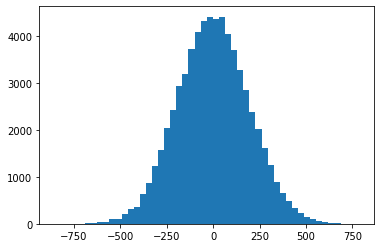

In [5]:
amplitude = get_amplitude(N=N, dim=dim, L=L, p_pow=p_pow, random_seed=random_seed)
amp_mask = generate_mask(N, dim, 0)
masked_amplitude = amp_mask*amplitude
field = np.fft.fftn(masked_amplitude)/(N*L)
plot_flattened_field(field, True)

# Random walk k$_{max}$

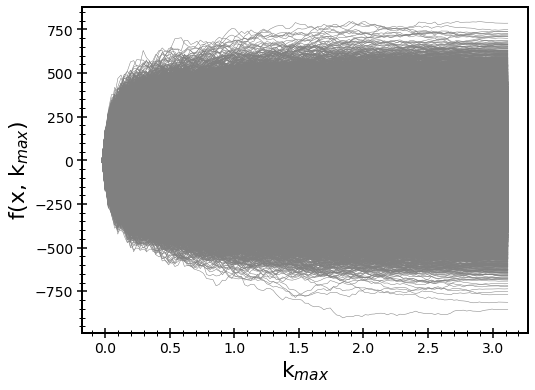

In [6]:
k_max_list = []
sample_points = []
for i in range(N):
    for j in range(N):
        sample_points.append([i,j])

rw = np.zeros(shape=(len(sample_points), len(range(int(N/2) + 1))))

for n_remove in range(int(N/2) + 1):
    amp_mask = generate_mask(N, dim, n_remove)
    k_max = del_k*((N/2) - 1 - n_remove)
    k_max_list.append(k_max)
    masked_amplitude = amp_mask*amplitude
    field = np.fft.fftn(masked_amplitude)/(N*L)
    real_field = np.real(field)
    rw[:, n_remove] = sample_field(sample_points, real_field, dim)
    
fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,6))

for i in range(rw.shape[0]):
    plt.plot(k_max_list, rw[i], lw=0.5, color='gray')
plt.xlabel(r"k$_{max}$", fontsize=22)
plt.ylabel(r"f(x, k$_{max}$)", fontsize=22)
tick_marks(ax, x1=0, x2=0, nx=0, dx=1, y1=0, y2=0, ny=0, dy=0, spwid=2, majortick_size=10, minortick_size=6, 
           majortick_width=1.5, minortick_width=1, tick_label_size=14)

# Incomplete and specific codes

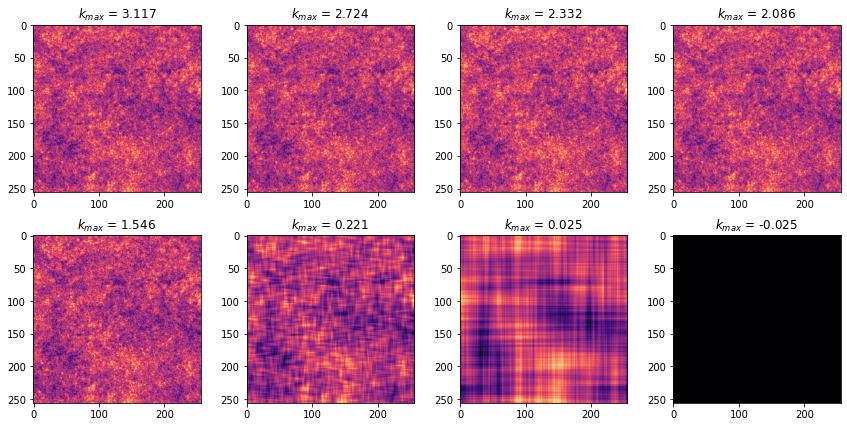

In [7]:
#Only for 2D
#Plot field for different k_max

plt.figure(figsize=(12,6))
for i, n_remove in enumerate([0, int(N/16), int(N/8), int(N/6), int(N/4), int(N/2) - 10, int(N/2) - 2, int(N/2)]):
    amp_mask = generate_mask(N, dim, n_remove)
    k_max = del_k*((N/2) - 1 - n_remove)
    masked_amplitude = amp_mask*amplitude
    field = np.fft.fftn(masked_amplitude)/(N*L)
    plt.subplot(2,4,i+1)
    plt.imshow(np.real(field), cmap='magma')
    plt.title(r"$k_{max}$ = %.3f"%(k_max))
    
plt.tight_layout()

In [ ]:
#Only for small number of sample points in 2D
#Overplot markers for sample points on a field with default k_max.

amp_mask = generate_mask(N, dim, 0)
masked_amplitude = amp_mask*amplitude
field = np.fft.fftn(masked_amplitude)/(N*L)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
plt.imshow(np.real(field), cmap='magma')
plt.ylim(ax.get_ylim())
plt.xlim(ax.get_xlim())
for i, sample_point in enumerate(sample_points):
    ax.add_patch(plt.Circle((sample_point[0], sample_point[1]), 8, color='k', fill=False, lw=2))
    plt.text(sample_point[0] + 10, sample_point[1], str(i+1), fontsize=18)